2018 Edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [62]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

from pyspark.mllib.stat import Statistics

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

# The below code is used to install external packages
import pip
def install(package):
   pip.main(['install', package])

# Set a default size for all the plots
matplotlib.rcParams['figure.figsize'] = (12.5, 5.0)
sns.set()

# We left this piece of code here only
# for debugging purposes. In fact, since
# we ran this notebook in our local environment
# we needed to build a SparkContext to be
# able to execute
try:
    sc
except NameError:
    # Define a dummy SparkContext
    sc = SparkContext("local[*]")
    # Define a different base path for dataset
    base = "datasets/lastfm/"
else:
    base = "/datasets/lastfm/"
    
sqlContext = SQLContext(sc)

<SparkContext master=local[*] appName=pyspark-shell>

### Question 1

#### Question 1.0 (Non-grading)
<div class="alert alert-info">
Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).
</div>

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

#### Answer 1.1: 

In [63]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

AnalysisException: 'Path does not exist: file:/datasets/lastfm/user_artist_data.txt;'

#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

#### Answer 1.1: 
<div class="alert alert-success">
They are 148.111
</div>

In [65]:
uniqueUsers = userArtistDF.select("userID").distinct().count()
print("Total n. of users: ", uniqueUsers)

Total n. of users:  50


#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

#### Answer 1.2: 
<div class="alert alert-success">
They are 1.6 millions (1.631.028) distinc artists.
</div>

In [4]:
uniqueArtists = userArtistDF.select("artistID").distinct().count()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  30677


#### Question 1.3
<div class="alert alert-info">
One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than `Integer.MAX_VALUE`, or `2147483647`, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.  

What are the maximum and minimum values of column `userID` ?  
</div>

#### Answer 1.3: 
<div class="alert alert-success">
Minimum `userID` value: 90<br>
Maximum `userID` value: 2443548<br>
Therefore the `userID` values conform to the MLLib requirements and there will be no problem is using them as they are.
</div>

In [67]:
userArtistDF.describe().show()

+-------+------------------+------------------+------------------+
|summary|            userID|          artistID|         playCount|
+-------+------------------+------------------+------------------+
|  count|             49481|             49481|             49481|
|   mean|1328420.1949435137|2003155.0297285826|130.57579677047755|
| stddev| 452991.3131262286|2489609.3644763026|3034.3847545693047|
|    min|           1000647|                 1|                 1|
|    max|           2288164|          10788218|            439771|
+-------+------------------+------------------+------------------+



None

#### Question 1.4
<div class="alert alert-info">
What is the maximum and minimum values of column `artistID` ?
</div>

#### Answer 1.4: 
<div class="alert alert-success">
As we have seen in the previous question, the values in which we are interested are:<br>
Minimum `artistID` value: 1<br>
Maximum `artistID` value: 10794401<br>
So the computed statistics that are printed reveal that the maximum user and artist IDs are 2443548 and 10794401, respectively. These are comfortably smaller than 2147483647 (which is `Integer.MAX_VALUE`). Therefore no additional transformation will be necessary to use these IDs. <br>
</div>

We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

#### Answer 2.1: 
<div class="alert alert-success">
The 5 most active users are those with the IDs shown in the below table.<br>

TODO: is the dataset relative to one single year?<br>

As we can see from the below query some users have a very high `playCount` value. As an example, if we consider the user with `userID` equals to `1059637`, assuming that songs have an average duration of 3 minutes, he listened to music for more than 1400 days. This value seems a bit strange and it may represent an outlier in our data.
</div>

In [6]:
# Compute user activity
# We are interested in how many playcounts each user has scored.

userActivityDF = userArtistDF.groupBy('userID').agg(sum('playCount').alias('playCount_total'))\
                .orderBy('playCount_total', ascending=0)\
                .cache()
userActivity = userActivityDF.collect()

userActivityDF.show(5)

+-------+---------------+
| userID|playCount_total|
+-------+---------------+
|1059637|         674412|
|2064012|         548427|
|2069337|         393515|
|2023977|         285978|
|1046559|         183972|
+-------+---------------+
only showing top 5 rows



In [7]:
userActivityDF.describe().show()

+-------+-----------------+------------------+
|summary|           userID|   playCount_total|
+-------+-----------------+------------------+
|  count|               50|                50|
|   mean|       1425085.08|         129220.42|
| stddev|494628.9174706192|115931.01878097818|
|    min|          1000647|             72855|
|    max|          2288164|            674412|
+-------+-----------------+------------------+



#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

#### Answer 2.2:

In [8]:
def cdf_plot(Y, xlabel, title):
    yvals=np.arange(len(Y))/float(len(Y))

    plt.semilogx( Y, yvals )
    plt.xlabel(xlabel)
    plt.ylabel('ECDF')
    plt.grid(True,which="both",ls="-")
    plt.title(title,fontsize=20)


    # Now we compute the percentiles
    percent25 = np.percentile(Y, 25)
    percent50 = np.percentile(Y, 50)
    percent75 = np.percentile(Y, 75)

    plt.vlines(percent25, 0, 0.25, linestyle="dashed", color = 'r')
    plt.hlines(0.25, 0, percent25, linestyle="dashed", color ='r')
    plt.vlines(percent50, 0, 0.5, linestyle="dashed", color = 'r')
    plt.hlines(0.5, 0, percent50, linestyle="dashed", color ='r')
    plt.vlines(percent75, 0, 0.75, linestyle="dashed", color = 'r')
    plt.hlines(0.75, 0, percent75, linestyle="dashed", color ='r')
    
    plt.axvline(x=percent25, linestyle=":", color='b')
    plt.axvline(x=percent50, linestyle=":", color='b')
    plt.axvline(x=percent75, linestyle=":", color='b')

    plt.yticks(np.arange(0,1.25,0.25))

    # Plot zoomed version
    
    print('5% percentile: ', np.percentile(Y, 5))
    print('25% percentile: ', percent25)
    print('50% percentile: ', percent50)
    print('75% percentile: ', percent75)
    print('90% percentile: ', np.percentile(Y, 90))

    plt.show()
    
def boxplot(Y, xlabel, title):
    sns.boxplot(Y)
    plt.xlabel(xlabel)
    plt.grid(True,which="both",ls="-")
    plt.xscale('log')
    plt.title(title,fontsize=20)

5% percentile:  73390.5
25% percentile:  76217.5
50% percentile:  82881.0
75% percentile:  134957.5
90% percentile:  176637.0


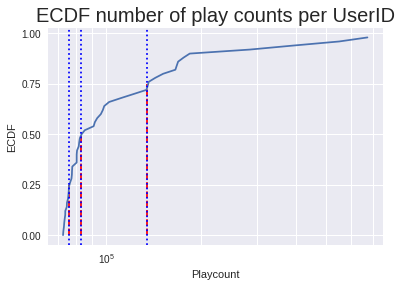

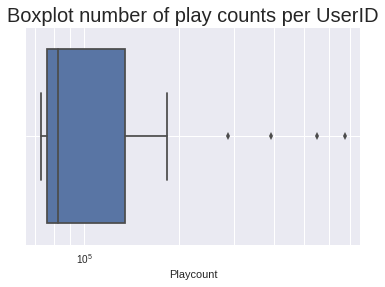

In [9]:
pdf   = pd.DataFrame(data=userActivity)

# UserActivity schema --> [UserID, playCount] 
Y     = np.array( pdf[1] )
Y = np.sort(Y)
cdf_plot(Y, "Playcount", "ECDF number of play counts per UserID")
boxplot(Y,"Playcount", "Boxplot number of play counts per UserID")

<div class="alert alert-success"> 
We produced two plots. One for the ECDF as demanded in the question, and one boxplot in order to get a better understanding of our data distribution. On both plots we have shown three additional lines denoting respectively the 25%, 50% and 75% percentiles.
<br>
As we can see 25% of the users has around 200 play counts and less than the 50% has less than 1000 play counts. Moreover we have 2008 as value for the 75% percentile. Of course, the more a user has play counts, the more accurate the recommendations for them will be.
<br>
The plot also shows that there are many users with very few `playCount` (around 10). Being able to suggest new songs to those kind of users may be very difficult for the ALS algorithm as there are very few information about their tastes. Therefore it is possible that, for those users, initial recommendations may not really reflect their real tastes but the algorithm will get better as the user becomes more active on the system.
<br>
The outlier values are quite visible in the box plot where they are on the right-most part of the scale. However we may consider as outliers also those values with very few play counts. At this point of our analysis we can not say if those values will compromise our model's performances but, since they represent a small portion of the whole dataset, it is likely that they will not create problems.
<br>
TODO: re-execute and check for the other percentile values to improve outliers answer.
</div>

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

#### Answer 2.3:

In [ ]:
# Read artist alias table
artistAliasSchema = StructType([ \
    StructField("misspelledArtistID", LongType(), True), \
    StructField("standardArtistID", LongType(), True)]) 
  
artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t') \
    .load(base + "artist_alias.txt", schema = artistAliasSchema) \

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistAliasDF.cache()

In [59]:
# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

############## QUESTO RISOLVE IL PROBLEMA DEI MISPELLED
#artistPopularityDF = userArtistDF.join(artistAliasDF,\
#                                       userArtistDF['artistID'] == artistAliasDF['misspelledArtistID'],\
#                                       'left_outer')\
#                                .withColumn('artist', when(isnull('standardArtistID'), userArtistDF['artistID'])\
#                                        .otherwise(artistAliasDF['standardArtistID']))\
#                                .groupBy('artist')\
#                                            .agg(sum('playCount').alias('playCount'))\
#                                            .orderBy('playCount', ascending=0)\
#                                .cache()
#artistPopularityDF.show(5)
#################
    
artistPopularityDF = userArtistDF.groupby("artistID").sum("playCount").collect().cache()
################# QUESTO NON È NECESSARIO, BASTA FARE LA UNA GROUP BY
#artistPlaycount = userArtistDF.join(artistAliasDF,\
#                                     userArtistDF['artistID'] == \
#                                      artistAliasDF['misspelledArtistID'],
#                                     'inner')\
#                                .select('artistID', 'playCount')    
# But in this way we are loosing the playcounts of the artists with the standardArtistID, so...
# First we create a df with the unique standardArtist names
#standardArtistDF = artistAliasDF.select("standardArtistID").distinct()

#otherArtistPlaycount = userArtistDF.join(standardArtistDF,\
#                                         userArtistDF['artistID'] == standardArtistDF['standardArtistID'] ,\
#                                         'inner')\
#                                    .select('artistID', 'playCount')
    
#artistPopularityDF = artistPlaycount.union(otherArtistPlaycount)\
#                    .groupBy('artistID')\
#                    .agg(sum('playCount').alias('playCount'))\
#                    .orderBy('playCount', ascending=0)\
#                    .cache()
#artistPopularityDF.show(5)

+-------+---------+
| artist|playCount|
+-------+---------+
|1002095|   539931|
|   4468|   441642|
|1026440|   163428|
|1007801|    94751|
|1004440|    70218|
+-------+---------+
only showing top 5 rows



5% percentile:  1.0
25% percentile:  2.0
50% percentile:  10.0
75% percentile:  72.5
90% percentile:  441.6


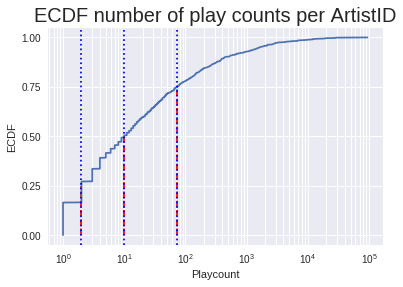

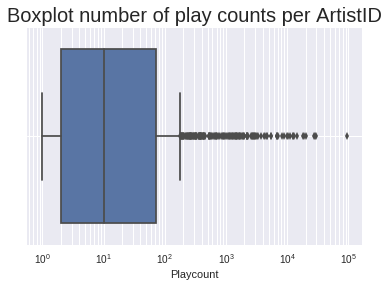

In [11]:
artistPopularity = artistPopularityDF.collect()
pdf = pd.DataFrame(data=artistPopularity)
# ArtistPopularity schema --> [ArtistID, playCount] 
Y     = np.array( pdf[1] )
Y = np.sort(Y)
cdf_plot(Y, "Playcount", "ECDF number of play counts per ArtistID")
boxplot(Y,"Playcount", "Boxplot number of play counts per ArtistID")


<div class="alert alert-success">
The artists' names could be misspelled or nonstandard, so we must use the `artist_alias.txt` dataset to put together all the artists' names aliases. The data in this file has 2 columns separated by tab characters (\t). <br>
The columns are: MisspelledArtistID, StandardArtistID.<br>
Our solution is to first join the `userArtistDF` with the `artistAliasDF` so that we obatin a table where, for each row, we have the `standardArtistID` and the `playCount`. <br>
However, in this way we lose the artists which already had a standard artist name. So we also create a dataframe with the unique standard artist names and then join it with the `userArtistDF`. <br>
At the end we will call a union on the two dataframes we created and we'll proceed with the query. <br>

<br>
Can we avoid all of that above mentioned process with a left join?
<br>
<br>

For the above plots we used the same plotting functions we used in the previous answer.
<br>
From the percentile analysis we can see that most of the play counts belong to a small fraction of all the artists. Even though this may seem quite a weird results we were somehow expecting it because, usually, the most popular artists are a very few portion of those in the catalog of online music services such as Last.fm.
<br>
This bias of play counts towards the most popular artists may make it difficult to recommend unpopular artists to those users who only listen to the most popular ones. However, those kind of users, are usually those who follow the trends and would be annoied if the system would recommend them to listen to classic music. Indeed we believe that the bias we observed is not necessarly a bad property of our dataset.
<br>
TODO: can we add something about outliers?
</div>

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 5 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-5 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

#### Answer 2.4:

In [71]:
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_data.txt", schema = customSchemaArtist) \
    .cache()

AnalysisException: 'Path does not exist: file:/datasets/lastfm/artist_data.txt;'

In [72]:
sub_artistPopularityDF = sqlContext.createDataFrame(artistPopularityDF.head(5))
top5_artistPopularity = sub_artistPopularityDF.join(artistDF, artistDF['artistID'] == sub_artistPopularityDF['artistID'] ,'inner').collect()

pdf                   = pd.DataFrame(data=top5_artistPopularity)
ax                    = sns.barplot(x=pdf[3], y=pdf[1], palette='magma')

plt.ylabel('Play Count')
plt.xlabel('Artist')
plt.title('Top-10 Artist ID per play counts',fontsize=20)
plt.show()

AnalysisException: 'Cannot resolve column name "artistID" among (artist, playCount);'

<div class="alert alert-success">
Results are quite reasonable. In fact looking at the top 5 artists gives us interesting information as they have most of the play counts of our dataset. Moreover, as we have already cleaned our data from mispelled `airtistID` we can not see any outlier worsening our results.
<br>
TODO: can we really tell something? Maybe we should not clean duplicates before this point!
</div>

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.  

<ul></ul>
<div class="label label-success">HINT:</div> If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

</div>

#### Ansert 3.1:

In [73]:
# Artist dataframe was already read for question 2.4
artistDF.show(5)

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1240105|        André Visior|
| 1240113|           riow arai|
| 1240132|Outkast & Rage Ag...|
| 6776115|                小松正夫|
| 1030848|      Raver's Nature|
+--------+--------------------+
only showing top 5 rows



#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  

<ul></ul>
<div class="label label-success">HINT:</div> Function `locate(sub_string, string)` can be useful in this case.
</div>

#### Answer 3.2:
<div class="alert alert-success">
Comment about the fact that there are a lot of names containing `Aerosmith`, and comment about the name of artistID 1000010 and 2082323.
</div>

In [74]:
# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", artistDF.name) > 0].show(20)

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()

+--------+---------+
|artistID|     name|
+--------+---------+
| 1000010|Aerosmith|
+--------+---------+

+--------+---------+
|artistID|     name|
+--------+---------+
| 1000010|Aerosmith|
+--------+---------+

+--------+----+
|artistID|name|
+--------+----+
+--------+----+



<div class="alert alert-success">
As we can see there are many artists containing 'Aerosmith' in their name. Some of them, specifically those with `artistID` equal to `1000010` and `2082323` (but also those with `artistID` equals to `10033592` or `10479781`), may seem to refer to the same artist and some of them may have a mispelled name. However, to be sure of this observation we need the data contained in the `artist_alias.txt` dataset and check if one of the mentioned `artistID` is acutally a mispelled artist ID or not.
</div>

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

#### Answer 3.3:
<div class="alert alert-success">
We have already loaded it in the answer 2.3. 
</div>

In [75]:
artistAliasDF.show(5)

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
|           1027859|         1252408|
|           1017615|             668|
|           6745885|         1268522|
|           1018110|         1018110|
|           1014609|         1014609|
+------------------+----------------+
only showing top 5 rows



#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

#### Answer 3.4
<div class="alert alert-success">
The two artists are the same. This is an example of how not considering all the aliases for a given artistID may lead to sloppy results in the artist popularity analysis. In fact `1000010` is a standard id, so it hasn't been considered as mispelled id in the dataset while, `2082323` refers to the standard artist Aerosmith. To confirm the observation we made on Question 2.4, we also analyzed artist ID `10033592` and `10479781` to check if they actually refers to the standard Aerosmith ID, and, since the last two queries produced an empty table, we can conclude that our intuition was correct.
</div>

In [76]:
artistAliasDF[artistAliasDF.misspelledArtistID == 1000010].show()
artistAliasDF[artistAliasDF.misspelledArtistID == 2082323].show()
artistAliasDF[artistAliasDF.misspelledArtistID == 10033592].show()
artistAliasDF[artistAliasDF.misspelledArtistID == 10479781].show()

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
+------------------+----------------+

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
+------------------+----------------+

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
+------------------+----------------+

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
+------------------+----------------+



### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
<div class="alert alert-info">
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.  

<div class="label label-success">HINT:</div> Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.
</div>

#### Answer 4.1:

In [77]:
artistAlias = artistAliasDF.rdd.map(lambda row: (row[0], row[1])).collectAsMap()

#### Question 4.2
<div class="alert alert-info">
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

#### Answer 4.2:

In [78]:
from time import time

def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
                        userArtistDF.rdd.map(replaceMispelledIDs),userArtistDataSchema\
                    )
newUserArtistDF.cache() # Cache the dataframe for obvious reasons
newUserArtistDF.show(5)

t1 = time()

print('The script takes %f seconds' %(t1-t0))

DataFrame[userID: bigint, artistID: bigint, playCount: int]

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1059637| 1000010|      238|
|1059637| 1000049|        1|
|1059637| 1000056|        1|
|1059637| 1000062|       11|
|1059637| 1000094|        1|
+-------+--------+---------+
only showing top 5 rows

The script takes 1.486193 seconds


<div class="alert alert-success">
In order to show that we fully solved the problem of having duplicate user IDs we followed three different approaches:
<ol>
    <li>We checked that the artist ID `2082323` (which we knew it was a mispelled artist ID) did not exist anymore</li>
    <li>We did a groupBy operation on both `userID` and `artistID` and counted how many couples of them there are. In fact, since we replaced the mispelled artist IDs with the standard ones, we were expecting duplicate (`userID`, `artistID`) pairs</li>
    <li>We did a join between the newly produced userArtist dataframe and the artist alias one, showing that the operation produced an empty set as result</li>
</ol>
</div>

##### Approach 1
<div class="alert alert-success">
As we were expecting the `artistID` `2082323` does not exist in the newly produced dataset.
</div>

In [79]:
newUserArtistDF[newUserArtistDF.artistID == 2082323].show()

+------+--------+---------+
|userID|artistID|playCount|
+------+--------+---------+
+------+--------+---------+



##### Approach 2
<div class="alert alert-success">
As we were expecting there are many duplicate (`userID`, `artistID`) pairs.
</div>

In [80]:
replaceCheck = newUserArtistDF.groupBy("userID","artistID").agg(count('*').alias("total"))
replaceCheck[replaceCheck.total > 1].show()


+-------+--------+-----+
| userID|artistID|total|
+-------+--------+-----+
|2064012| 1001597|    2|
|1000647| 1263049|    2|
|1031009| 1012457|    2|
|2010008| 1104179|    2|
|2014936| 1006485|    2|
|2023686| 1203762|    2|
|1035511|    5810|    2|
|1026084| 1007885|    2|
|1001440| 1291109|    2|
|2010008| 1249401|    2|
|1021501| 2093800|    2|
|1041919| 1000602|    3|
|1035511| 1094137|    2|
|1024631| 1003556|    2|
|1058890| 1000088|    2|
|2023686| 1254644|    3|
|1031009| 1259297|    3|
|1007308| 1034635|    2|
|1029563| 1254973|    2|
|1017610| 1044253|    2|
+-------+--------+-----+
only showing top 20 rows



##### Approach 3
<div class="alert alert-success">
The first result of this approach (which is also the most computationally expensive among the ones which we used) shows that, even though we were expecting an empty set as a result of our query, we are actually obtaining many rows in which the `mispelledArtistID` matched with the standard one.
</div>

In [81]:
newUserArtistDF.join(artistAliasDF, newUserArtistDF["artistID"] == artistAliasDF["misspelledArtistID"], 'inner').show()

+-------+--------+---------+------------------+----------------+
| userID|artistID|playCount|misspelledArtistID|standardArtistID|
+-------+--------+---------+------------------+----------------+
|2069337| 1014609|       61|           1014609|         1014609|
|1046559| 1001864|       42|           1001864|         1001864|
|1046559|      15|       63|                15|              15|
|1052461| 1001864|        2|           1001864|         1001864|
|1052461|     754|      186|               754|             754|
|1031009| 1001864|       37|           1001864|         1001864|
|1031009|      15|     1127|                15|              15|
|2020513|     754|      993|               754|             754|
|2062243| 1014609|      392|           1014609|         1014609|
|2062243|     754|        2|               754|             754|
|1001440|      15|      956|                15|              15|
|1001440|     754|     1512|               754|             754|
|2014936| 1014609|       

<div class="alert alert-success">
In fact there are some "loops" in the `artistAlias` dataset which means that there are some entries in which the mispelled artist ID is recorded to be the same as the standard artist ID. To check that we really performed a good replacement of our mispelled IDs we need to use an additional filter in our query:
</div>

In [82]:
newUserArtistDF.join(artistAliasDF, newUserArtistDF["artistID"] == artistAliasDF["misspelledArtistID"], 'inner')\
                .filter(artistAliasDF["artistID"] == artistAliasDF["misspelledArtistID"]).show()

AnalysisException: 'Cannot resolve column name "artistID" among (misspelledArtistID, standardArtistID);'

<div class="alert alert-success">
TODO: where to put this? TO BE CHANGED. The problem of having duplicate `(user, artist)` pairs is fully solved by calling the `reduceByKey` function. The `map` call is used both to perform duplicate elimination and to impose the key-value pair format to our distributed data, indeed it emits tuples where the key is the `artistID`, and the value is the whole row, with the proper `artistID`. After that call the `reduceByKey` collects those key-value pairs and emits tuples (or rows of the dataframe) with the aggregated value for the `playCount` field. 
</div>

#### Question 4.3
<div class="alert alert-info">
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task.   
<ul> </ul>
We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner.   
<ul></ul>
The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`  

<ul></ul>
To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.
</div>


#### Answer 4.3:
<div class="alert alert-success">
The advantage of using a broadcast variable is that in this way we can ship to all workers a copy of the `artistAlias` map. The main advantage of this is that, if we did not use a broadcast variable, we would have need to ship the `artistAlias` map in a serialized format to each task and each task will have had to deserialize it when needed. Using a broadcast variable, instead, the `artistAlias` map is broadcasted only once and each worker is able to keep a deserialized cached version of it in its own memory. Obviously this improves the efficiency of our algorith.
</div>

In [83]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
                    userArtistDF.rdd.map(replaceMispelledIDs),userArtistDataSchema\
                    )
newUserArtistDF.cache() # Caching for obvious reasons
newUserArtistDF.show(5)
t1 = time()

print('The script takes %f seconds' %(t1-t0))


DataFrame[userID: bigint, artistID: bigint, playCount: int]

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1059637| 1000010|      238|
|1059637| 1000049|        1|
|1059637| 1000056|        1|
|1059637| 1000062|       11|
|1059637| 1000094|        1|
+-------+--------+---------+
only showing top 5 rows

The script takes 1.107161 seconds


Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

#### Answer 5.1:
<div class="alert alert-success">
There used to be `1.631.028` distinc artist IDs while now we only have `1.568.126` distinc values of them. Therefore we can say that we have eliminated `62.902` redundant artist IDs from our dataset.
</div>

In [84]:
uniqueArtists = newUserArtistDF.select('artistID').distinct().count()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  30100


#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artistis?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
<div>

#### Answer 5.2:

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

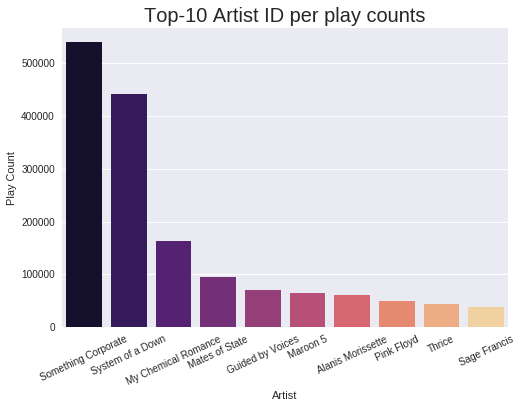

In [93]:
# calculate top-10 artists in term of play counts
top10ArtistPCDF = newUserArtistDF.groupBy('artistID').sum('playCount').orderBy('sum(playCount)', ascending=0)
top10ArtistPC_tmp = sqlContext.createDataFrame(top10ArtistPCDF.head(10))
top10ArtistPCDF = top10ArtistPC_tmp.join(artistDF, top10ArtistPC_tmp['artistID'] == artistDF['artistID'], 'inner').cache()
top10ArtistPC = top10ArtistPCDF.collect()

pdf            = pd.DataFrame(data=top10ArtistPC)
ax             = sns.barplot(x=pdf[3], y=pdf[1], palette='magma')

plt.ylabel('Play Count')
plt.xlabel('Artist')
plt.xticks(rotation=25)
plt.title('Top-10 Artist ID per play counts', fontsize=20)
plt.show()

In [86]:
# Install the requested module to plot the word cloud
%%capture
install('wordcloud')

(-0.5, 1023.5, 399.5, -0.5)

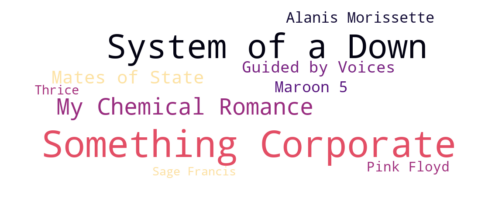

In [101]:
# wordmap
from wordcloud import WordCloud
artistActivityMap = top10ArtistPCDF.rdd.map(lambda row: (row['name'], row['sum(playCount)']))\
                        .collectAsMap()
wordcloud = WordCloud(background_color='white', width=1024, height=400, colormap='magma').generate_from_frequencies(artistActivityMap)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

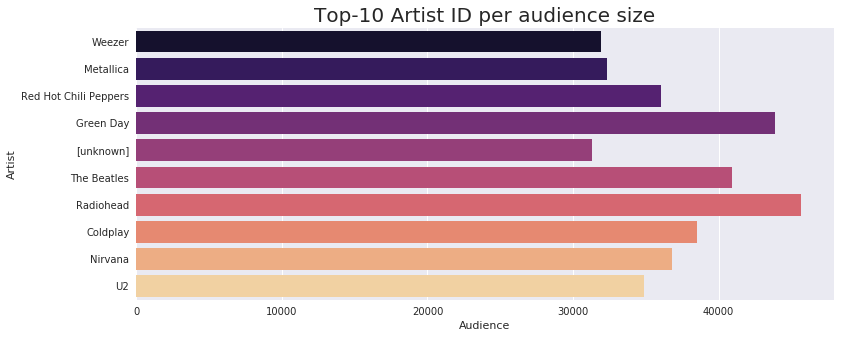

In [129]:
# calculate top-10 artists in term of audience size
top10ArtistASDF = newUserArtistDF.groupBy('artistID')\
                    .agg(countDistinct('userID').alias("audience"))\
                    .orderBy('audience', ascending=0)
top10ArtistAS_tmp = sqlContext.createDataFrame(top10ArtistASDF.head(10))
top10ArtistAS = top10ArtistAS_tmp.join(artistDF, top10ArtistAS_tmp['artistID'] == artistDF['artistID'], 'inner').collect() 

pdf            = pd.DataFrame(data=top10ArtistAS)

ax             = sns.barplot(x=pdf[1], y=pdf[3], palette = 'magma')
plt.xlabel('Audience')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience size', fontsize = 20)
plt.show()

<div class="alert alert-success">
From the above plots we can see that, more or less, the top 10 artists per play counts and the top 10 artists per audice size are quite similar between each other. However some artists have higher audience size e.g. Green Day than play count, meaning that more people listen to them but very few of those people listen to them very frequently. We also have opposite situation with The Beatles which is 2nd in the play count rating but with a lower audience size score. Moreover we have some artists e.g. Pink Floyd that, despite the fact that they have a huge number of play counts, they do not appear in the top 10 per audience size. This may means that they have fewer but very loyal fans.
<br>An additional information we can see from the audience size plot is that our dataset still contains a lot of songs whose artist is marked as `[unknown]`. Unfortunatelly this is not a problem we can solve by outselves.
</div>

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

#### Answer 5.3

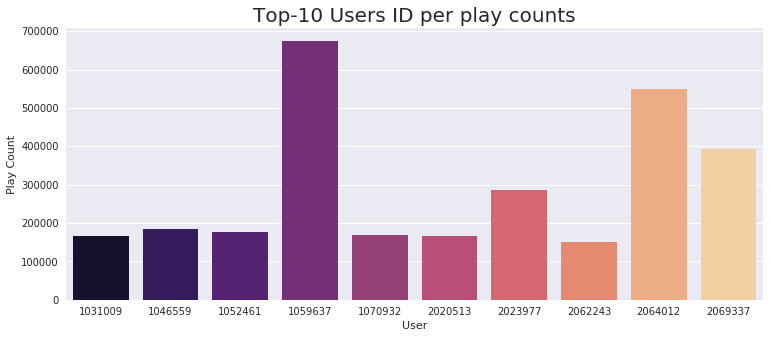

In [157]:
# calculate top 10 users in term of play counts
top10UserPC = newUserArtistDF.groupBy('userID').sum('playCount').orderBy('sum(playCount)', ascending=0).take(10)

pdf                   = pd.DataFrame(data=top10UserPC)

ax                    = sns.barplot(x=pdf[0], y=pdf[1], palette='magma')

plt.ylabel('Play Count')
plt.xlabel('User')
plt.title('Top-10 Users ID per play counts', fontsize=20)
plt.show()

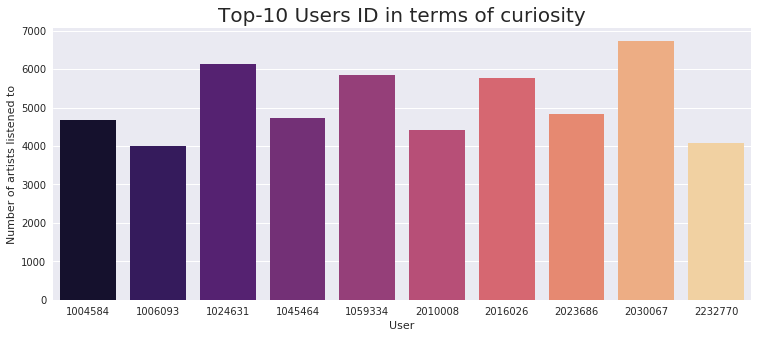

In [158]:
# calculate top 10 users in terms of curiosity
top10UserC = newUserArtistDF.groupBy('userID')\
                                .agg(countDistinct('artistID').alias("listenedArtists"))\
                                .orderBy('listenedArtists', ascending=0).take(10)


pdf                   = pd.DataFrame(data=top10UserC)

ax                    = sns.barplot(x=pdf[0], y=pdf[1], palette='magma')

plt.ylabel('Number of artists listened to')
plt.xlabel('User')
plt.title('Top-10 Users ID in terms of curiosity', fontsize=20)
plt.show()

<div class="alert alert-success">
By compraing the two plots, the first thing we can see it that, how we were expecting, there some outliers in our dataset. For example let's consider the user with ID `1059637`. He has an enormous play count value if compared to the other users but he does not even appear in the top-10 in terms of curiosity. The same applies to users with ID `2064012` and `206937`. It means that those users probably listen to the same few songs over and over but the huge values of their play count make us think that they are certainly outlisers.
<br>
However we can see that there is no user in common in the two plots. It means that Last.fm users could be classified in two groups: those who are very active but listen to a very few number of artists and those who do not listen to music very often but when they do they explore new songs.
</div>

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1

<div class="alert alert-info">
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.
</div>

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

#### Answer 6.1:

In [85]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map(xtractFields)
    
                    # fileter out the special tuples
                    .filter(lambda x: x[0]>0 and x[1]>0)
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )

#### Question 6.2
<div class="alert alert-info">
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.
</div>

HINT: Using broadcast varible can help us increase the effiency.

#### Answer 6.2:
<div class="alert alert-success">
Also userArtistDataRDD should be cleaned, so we used a modified version of `xtractFields` also here.
</div>

In [86]:
def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,2)
    # if this line has at least 2 characters
    if (len(line) > 2):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]), int(line[2]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1,-1)

bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split()
    finalArtistID = bArtistAlias.value.get(artistID, artistID)
    return " ".join([userID, finalArtistID, count])

userArtistDataRDD = rawUserArtistData.map(disambiguate)\
                                .map(xtractFields)\
                                .filter(lambda x: x[0]>0)\

# after replacing mispelled artist ids, the data contains some play count 
# duplications of a user with the same artist. Let's aggregate those records. 
# First "Group By" UserId and ArtistId and then compute aggregated playCount.
userArtistDataRDD.map(lambda r: ((r[0], r[1]), r[2]))\
                    .reduceByKey(lambda x, y: x + y)
userArtistDataRDD.cache()

PythonRDD[755] at RDD at PythonRDD.scala:48

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
<div class="alert alert-info">
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.
</div>

#### Answer 7.1:

In [87]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [88]:
# Based on the RDD we produced for question 6.2, turn the data into Rating objects
trainingData = userArtistDataRDD\
            .map(lambda r: Rating(r[0][0], r[0][1], r[1]))\
            .repartition(8).cache()

<div class="alert alert-success">
We did nothing but turning out data into `Rating` objects. The only additional operation we performed is the `repartition(8)`. Here we are basically forcing our dataset to be divided into 8 partitions, spread over the workers in our cluster. We choose the number 8 simply because we have 4 workers in our cluster. Any multiple of 4 could have been used instead of 8, even though it would be advisable not to use too big values. The reason behind this is the fact that Spark will schedule one task per partition and, using a big value e.g. 256, will force Spark to schedule 64 tasks on each of our worker and each task will operate on a very small subset of the orginal dataset, introducing a lot of unnecessary overhead.
</div>

#### Question 7.2
<div class="alert alert-info">
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
<ul>
<li>`training data` is the input data you decide to feed to the ALS algorithm</li>
<li>`rank` is the number of laten features</li>
</ul>  


We can also use some additional parameters to adjust the quality of the model. Currently, let's set 
<ul>
<li>`rank=10`</li>
<li>`iterations=5`</li>
<li>`lambda_=0.01`</li>
<li>`alpha=1.0` </li>
</ul>
to build model.
</div>

#### Answer 7.2:

In [89]:
t0 = time()
model = ALS.trainImplicit(trainingData, rank=10, iterations=5, lambda_=0.01, alpha=1.0 )
t1 = time()
print("Finish training model in %f secs" % (t1 - t0))

finish training model in 129.907259 secs


#### Question 7.3
<div class="alert alert-info">
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.
</div>

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

#### Answer 7.3:

In [90]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
t0 = time()
model.save(sc, "lastfm_model.spark")
t1 = time()
print("Finish saving model in %f secs" % (t1 - t0))

finish saving model in 6.943370 secs


<div class="alert alert-success">
TODO: which one takes longer? Training or saving?
</div>

#### Question 7.4
<div class="alert alert-info">
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.
</div>

#### Answer 7.4:

In [91]:
t0 = time()
model = MatrixFactorizationModel.load(sc, "lastfm_model.spark")
t1 = time()
print("Finish loading model in %f secs" % (t1 - t0))

finish loading model in 2.323744 secs


#### Question 7.5
<div class="alert alert-info">
Print the first row of user features in our model.
</div>

#### Answer 7.5:

In [92]:
model.userFeatures().take(1)

[(116,
  array('d', [-0.060547906905412674, 0.01603700965642929, -0.04351115599274635, -0.004681801423430443, 0.03316757455468178, 0.04180077835917473, 0.012456522323191166, -0.005576193332672119, -0.005481611471623182, -0.028712309896945953]))]

### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try with different users!).
</div>

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

#### Answer 8:

In [152]:
# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)

In [103]:
# Filter in those artists, get just artist, and print
def artistNames(row):
    # row is a tuple containing (artistID, name)
    return len(row) > 0 and row[0] in recArtist

# Users to give recommendations to
users = [2093760, 2030067, 1024631, 1059334, 2016026, 2023686]

for u in users:
    # Make five reccommendations to user 2093760
    recommendations = model.recommendProducts(2093760, 5)
    # construct set of recommendated artists
    recArtist = [r.product for r in recommendations]
    recList = artistByID.filter(artistNames).values().collect()

    print('Recommendations for user', u,':\n',recList)

['50 Cent', 'Snoop Dogg', 'Ludacris', '2Pac', 'The Game']


<div class="alert alert-danger">
At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.
</div>

In [104]:
def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

#### Answer 9.1:

In [105]:
trainData, cvData = trainingData.randomSplit([0.9, 0.1], seed=7)
trainData.cache()
cvData.cache()

PythonRDD[961] at RDD at PythonRDD.scala:48

In [106]:
t0 = time()
model = ALS.trainImplicit(trainData, rank=10, iterations=5, lambda_=0.01, alpha=1.0 )
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 65.777057 secs


#### Area under the ROC curve: a function to compute it

In [159]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(trainingData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [109]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
<div class="alert alert-info">
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.
</div>

#### Answer 9.2:

In [110]:
t0 = time()
auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)
t1 = time()
print("AUC =",auc)
print("Finish in %f seconds" % (t1 - t0))

auc= 0.9642663565522145
finish in 44.112271 seconds


#### Question 9.3
<div class="alert alert-info">
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective.   
<ul></ul>
Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.
</div>

#### Answer 9.3:

In [111]:
# pc stands for playCount
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda pc1, pc2: pc1 + pc2).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get(r[1] , 0.0)))

In [112]:
auc = calculateAUC(cvData, bAllItemIDs, predictMostListened)
print(auc)

0.9370097973636369


<div class="alert alert-success">
The result is about 0.93. This suggests that nonpersonalized recommendations are
already fairly effective according to this metric. Now we need to see if the built model, if properly tuned, can beat this simple approach.
</div>

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

#### Answer 10.1:

In [113]:
# Train a model for each combination of the parameters
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(trainData, rank, iterations=5, lambda_=lambda_, alpha=alpha)
            
            auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000


In [114]:
# Look for the best combination of parameters
evaluations.sort(key=lambda tup: tup[1], reverse=True)
                
evalDataFrame = pd.DataFrame(data=evaluations, columns=['Params (rank, lambda, alpha)', 'UAC'])
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

  Params (rank, lambda, alpha)       UAC
0              (10, 1.0, 40.0)  0.977010
1              (50, 1.0, 40.0)  0.976226
2           (50, 0.0001, 40.0)  0.975187
3           (10, 0.0001, 40.0)  0.974763
4               (10, 1.0, 1.0)  0.968913
5               (50, 1.0, 1.0)  0.966850
6            (10, 0.0001, 1.0)  0.963313
7            (50, 0.0001, 1.0)  0.953809


PythonRDD[961] at RDD at PythonRDD.scala:48

<div class="alert alert-success">
The best combination of parameters is the following:
<ul>
    <li>rank = 10</li>
    <li>lambda = 1</li>
    <li>alpha = 40</li>
</ul>
</div>

#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

#### Answer 10.2:

In [117]:
# Train the model
rank, lambda_, alpha = evaluations[0][0]
model = ALS.trainImplicit(trainData, rank=rank, iterations=5, lambda_=lambda_, alpha=alpha)
trainingData.unpersist()

MapPartitionsRDD[760] at coalesce at NativeMethodAccessorImpl.java:0

In [157]:
# Do 5 recommendations for user 2093760 
userID = 2093760
recommendations = model.recommendProducts(userID, 5)

# construct set of recommendated artists
recArtist = [r.product for r in recommendations]

def artistNames(line):
    # [artistID, name]
    return (line[0] in recArtist)

# Using the same artistByID structure built while answering to question 8
recList = artistByID.filter(artistNames).values().collect()

print('Artists recommended for user 2093760:', recList)

unpersist(model)

AttributeError: 'CosineRecommender' object has no attribute 'recommendProducts'

<div class="alert alert-success">
The above cell show the new recommendations we are able to make for user `2093760`. In questions 8 we already did some recommendations for the same user and those were the following: `['50 Cent', 'Snoop Dogg', 'Ludacris', '2Pac', 'The Game']`.
<br>
As we can see they are quite different, both in terms of artist names and in terms of genres, and so we can conclude that our new model represents an important performances improvements with respect to the first one we built. Of course here we are saying that there is a performance improvement because of the compute AUC values.
</div>

# 4. Alternative Models

In this section we will show two alternative models to the ALS algorithm. The first is based on a local k-NN and the second one relies on a distributed implementation of the k-Means algorithm.

Before starting with the analysis of our models we first need to create a matrix with one line for each `artistID` and one column for each `userID`, in which `matrix[i][j] = playcounts` of user i for artist j. It will be our utility matrix.

In [119]:
#<schema> = <artistID, PC user1, PC user2, ..., PC userN> 
matrix = newUserArtistDF.groupBy('artistID').pivot('userID').sum('playCount').cache()

## 4.1 k-NN

The first alternative approach we analyzed is based on a k-NN, using **cosine similarity** as distance measure. This model is a slight variation of the original k-NN algorithm because the parameter k is variable and represents the amount of suggestions we want to provide to the user.

We decided not to parallelize this model because of the notorious complexity of having a distributed k-NN algorithm and also because what we are interested in are only the results. In fact, at the end of this subsection, we will compare all the results we obtained by using all the models we took into account.

The k-NN recommender was implemented by leveraging on an already existing library called `implicit`.

In [107]:
%%capture
# First we need to install required dependency
install('implicit')

In [158]:
from scipy.sparse import coo_matrix
from implicit.nearest_neighbours import CosineRecommender

def map_artistid_name(element):
    return 

class KNNCosineRecommender:    
    def _prepare_data(self):
        """ create a sparse matrix of all the users/plays """
        self.data['artistID'] = self.data['artistID'].astype("category")
        self.data['userID'] = self.data['userID'].astype("category")
        plays = coo_matrix((self.data['playCount'].astype(np.float32),
                           (self.data['artistID'].cat.codes.copy(),
                            self.data['userID'].cat.codes.copy())))
        return plays

    def train_model(self, data):
        """ 
        Generates an artists recommendations system using a k-NN model
        with cosine distance measure
        """
        # prepare data for the model
        self.data = data
        self.plays = self._prepare_data()

        # create and train our model
        self.model = CosineRecommender()

        # use SciPy's compressed sparse row format
        self.plays = self.plays.tocsr()

        # train our model
        self.model.fit(self.plays)

    def calculate_recommendations(self, user, k=5):
        """ Generates artist recommendations for each user in the dataset """
        # generate recommendations for the given user
        artists = dict(enumerate(self.data['artistID'].cat.categories))
        user_plays = self.plays.T.tocsr()
        rec = set()
        userid = self.data[self.data.userID == user].index[0]
        for artistid, score in self.model.recommend(userid, user_plays):
            rec.add(artists[artistid])
            if len(rec) == k:
                break

        return rec

# Create a new model object
knn = KNNCosineRecommender()
# train model
knn.train_model(newUserArtistDF.toPandas())
# show recommendations
rec = knn.calculate_recommendations(2093760)
recList = artistByID.filter(lambda x: x[0] in recArtist).values().collect()
print('Artists recommended for user 2093760:', rec)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: file:/datasets/lastfm/artist_data.txt
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:287)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:229)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:315)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:200)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:253)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:251)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:251)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:35)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:253)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:251)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:251)
	at org.apache.spark.api.python.PythonRDD.getPartitions(PythonRDD.scala:53)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:253)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:251)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:251)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2092)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


## 4.2 K-means

Our first approach in building a new recommendation system is a k-means with k = 20. We first create k clusters by measuring the item-item similarity, i.e, the similarity between `artistIDs`. <br>
The distance metric is the Cosine distance.<br> 
We will keep track of the clusterID for each `artistID`, s.t., given the most played artist for an user, we can suggest him other artists from the same cluster. <br>
Since we'll have a lot of `artistIDs` per cluster, we have to choose some criteria in selecting the ones to suggest, e.g: random, or the most played `artistIDs`. 


In [103]:
import time 
import sys

def pointsToCluster(data):
    X_points = np.array((list(data)))
    #len(X_points)-1 because we have to drop the artistID
    distance_matrix = np.zeros((len(X_points)-1, bcK.value))
    # ---------------
    # ASSIGNMENT STEP
    # ---------------
    # compute the distance matrix between each data point and the set of centroids
    # distance_matrix = # row Index = data point Index; col Index = centroid Index; value=distance 
    # a row for each artistID
    # a column for each centroid
    for i in range(bcK.value):
        distance_matrix[:,i] = np.sum(X_points[1:] * bcCentroids.value[i])/(np.sum(np.power(X_points[1:],2))*np.sum(np.power(bcCentroids.value[i],2)))
            
    # assign each data point to the closest centroid
    # cluster_assignment = # array Index = data point Index; array value = closest centroid Index      
    cluster_assignment = np.argmin(distance_matrix,axis=1)
   
    tuple_x_1 = zip(X_points, np.ones((len(X))))
    result = list(zip( cluster_assignment,  tuple_x_1))
    
    #print(result)
    return result

def reduce_sum(p1, p2):
    #print("SUM p1: {}".format(p1))
    #print("SUM p2: {}".format(p2))
    return (p1[0]+p2[0], p1[1]+p2[1])

def reduce_avg(x):
    #print("AVG: {}".format(x))
    point = np.array(x[1][0])
    size = np.array(x[1][1])
    #print(point)
    #print(size)
    avg = point/size
    #print(avg)
    return avg

start_time = time.time()



# Select k and maxiter
k = 20
maxiter = 20
nm = 4

X_points = matrix.rdd
X_points.cache()

# Random initialization
centroids = X_points[np.random.random_integers(0,len(X_points)-1,k)]
bcK = sc.broadcast(k)

# This for loop is executed by the driver
for itr in range(maxiter): 
    bcCentroids = sc.broadcast(centroids) 
    
    # in closest we have <clusterID, artistID, artistID row, 1> 
    closest = (   datapoints
                 .mapPartitions(pointsToCluster))

    centroids = np.array( 
                  closest.reduceByKey(reduce_sum)
                  .map(reduce_avg)
                  .collect()
                )
# Now we have in clostest RDD <clusterID, artistID, artistID row, 1> 
# we want to create a new DF with just <clusterID, artistID>
suggestionSchema = StructType([ \
    StructField("clusterID", LongType(), True),
    StructField("artistID", LongType(), True)])

suggestions = createDataFrame(closest.map(lambda row: row[0], row[1]), schema = suggestionSchema )

    
print("Final centroids")
print(centroids)
print("--- %s seconds ---" % (time.time() - start_time))

NameError: name 'matrix' is not defined

# 5. Models Comparison

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)